In [1]:
# Imports and Helpers

import os
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


def imread_rgb(path):
    return cv2.imread(imgpath)[:, :, ::-1]

# Camera calibration and warping

Loaded calibration coefficients


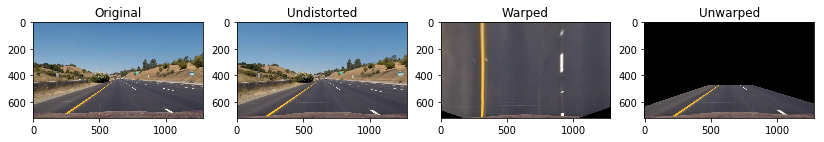

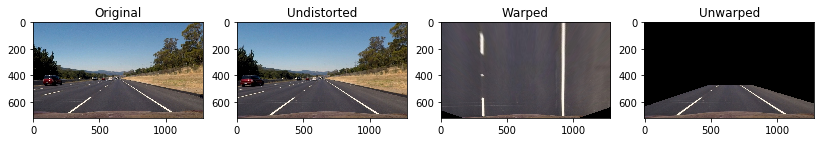

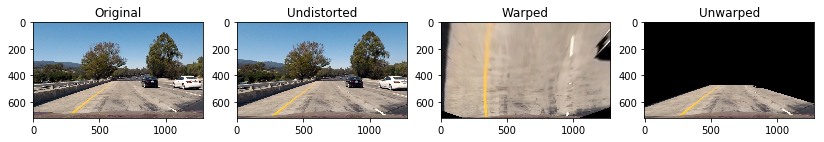

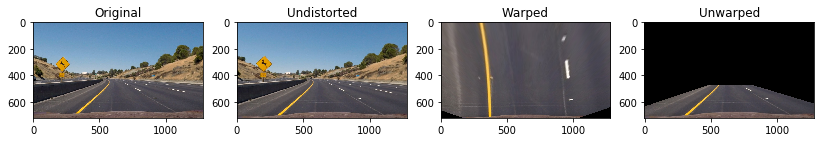

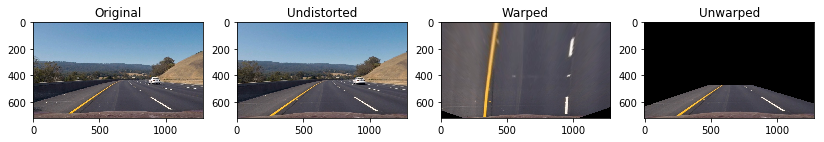

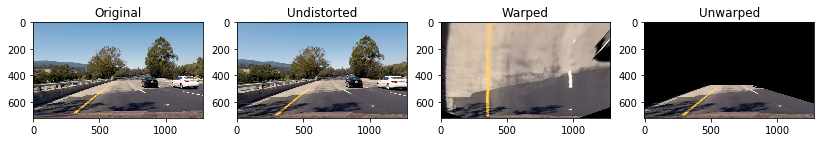

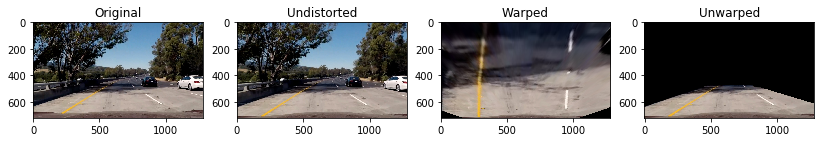

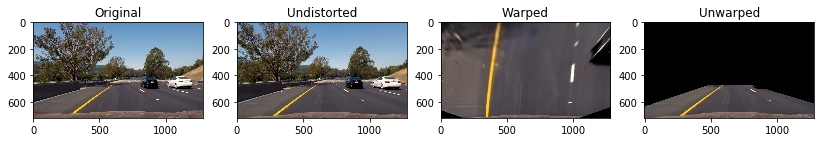

In [2]:
class Camera(object):
    
    def __init__(self):
        self.mtx = None
        self.dist = None
        src = np.float32([(220, 720), 
                          (570, 470), 
                          (720, 470),
                          (1110, 720)])
        dst = np.float32([(320, 720), 
                          (320, 0), 
                          (920, 0),
                          (920, 720)])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def calibrate(self):
        try:
            with open('camera.p', 'rb') as f:
                dist_pickle = pickle.load(f)
            self.mtx = dist_pickle['mtx']
            self.dist = dist_pickle['dist']
            print('Loaded calibration coefficients')
            return
        except:
            print('Calibrating camera')

        nx, ny = 9, 6
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)
        objpoints, imgpoints = [], []

        for imgpath in glob('./camera_cal/*.jpg'):
            img = cv2.imread(imgpath)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret is True:
                imgpoints.append(corners)
                objpoints.append(objp)

        ret, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        with open('camera.p', 'wb') as f:
            pickle.dump({
                'mtx': self.mtx,
                'dist': self.dist
            }, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def undistort(self, image):
        if self.mtx is None:
            self.calibrate()
        
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def warp(self, image):
        return cv2.warpPerspective(image, self.M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    def unwarp(self, image):
        return cv2.warpPerspective(image, self.M_inv, image.shape[1::-1], flags=cv2.INTER_LINEAR)

camera = Camera()
for imgpath in glob('./test_images/*.jpg'):
    img = imread_rgb(imgpath)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    undist = camera.undistort(img)
    ax2.imshow(undist)
    ax2.set_title('Undistorted')
    warped = camera.warp(undist)
    ax3.imshow(warped)
    ax3.set_title('Warped')
    unwarped = camera.unwarp(warped)
    ax4.imshow(unwarped)
    ax4.set_title('Unwarped')
    plt.show()

# Color filter

Here a binary image is built using color thresholds to make the lane pixels dominate the image.

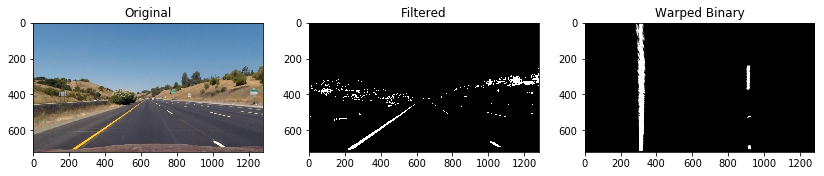

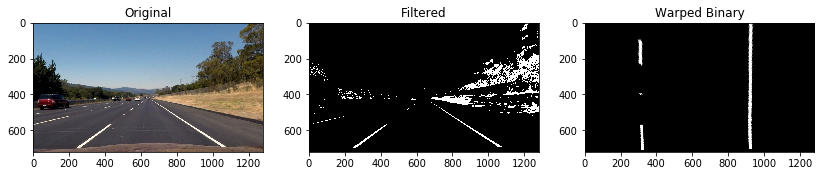

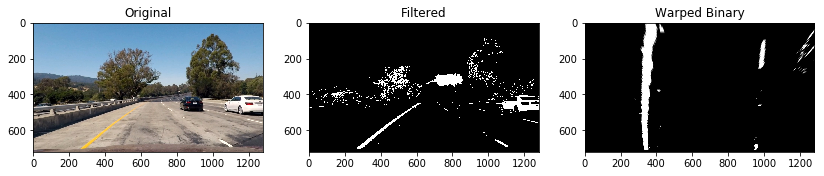

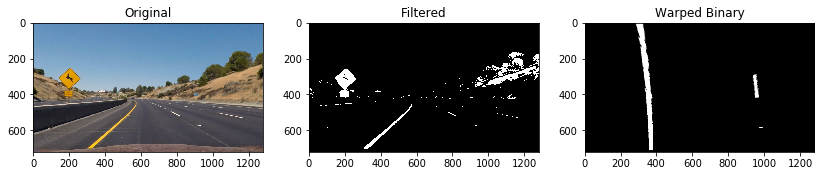

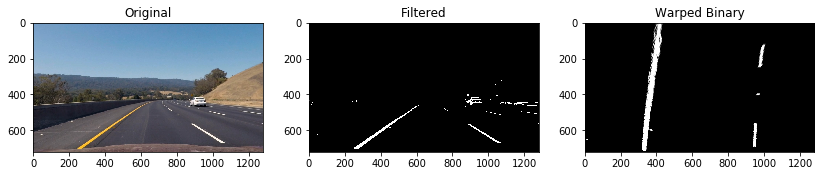

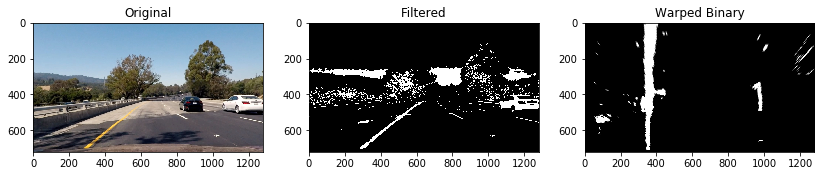

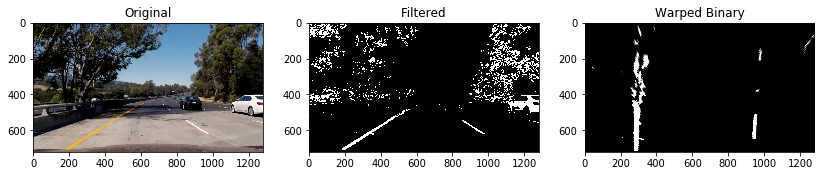

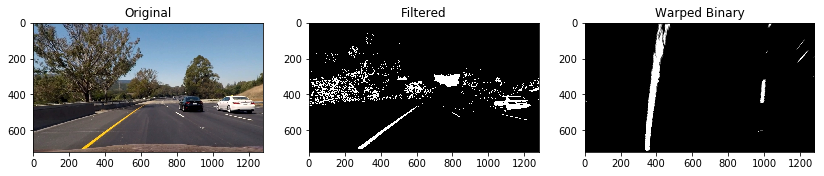

In [3]:
def color_filter(original):
    image = cv2.cvtColor(original, cv2.COLOR_RGB2HLS)
    white_mask = cv2.inRange(
        image,
        np.uint8([0, 200, 0]),
        np.uint8([255, 255, 255]),
    )
    yellow_mask = cv2.inRange(
        image,
        np.uint8([10, 0, 100]),
        np.uint8([40, 255, 255]),
    )
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return mask

for imgpath in glob('./test_images/*.jpg'):
    img = camera.undistort(imread_rgb(imgpath))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    filtered = color_filter(img)
    ax2.imshow(filtered, cmap='gray')
    ax2.set_title('Filtered')
    ax3.imshow(camera.warp(filtered), cmap='gray')
    ax3.set_title('Warped Binary')
    plt.show()

# Finding centroids

This technique uses np.convolve to find the position of the lane pixels.

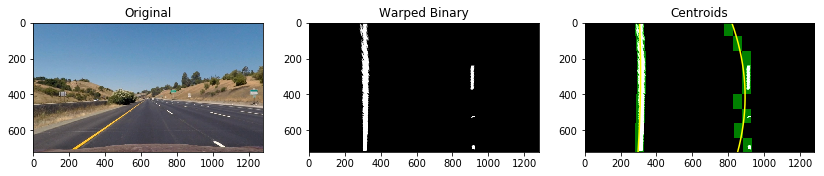

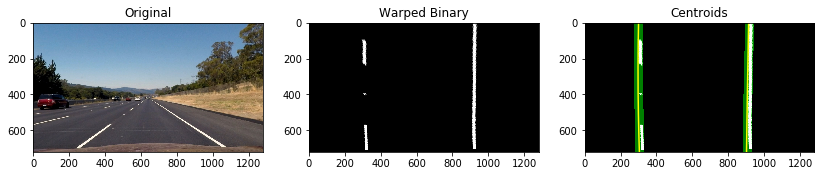

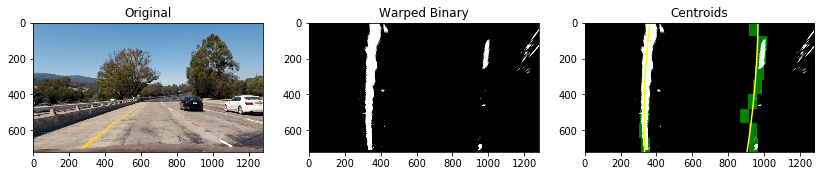

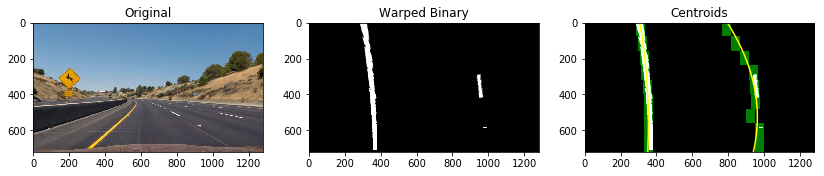

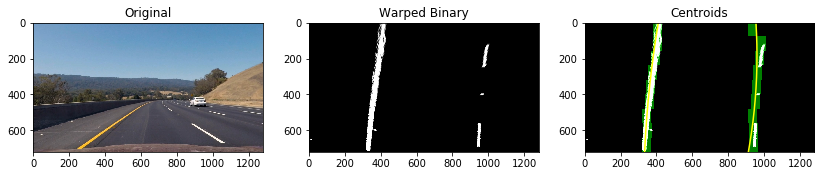

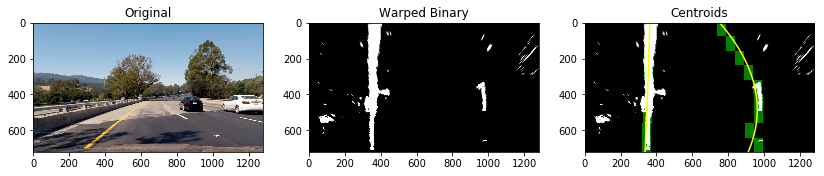

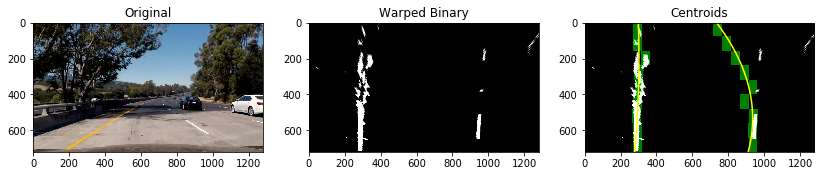

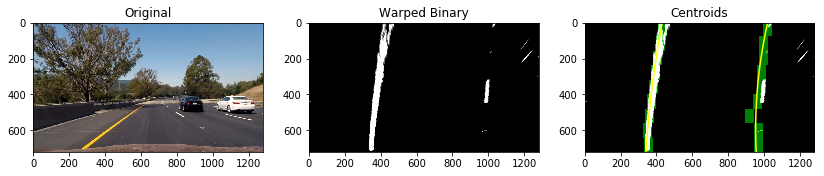

In [4]:
def find_window_centroids(image, window_width=50, window_height=80, margin=100):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_window = conv_signal[l_min_index:l_max_index]
        if np.max(l_window) > 0: # Doesn't update if nothing is found
            l_center = np.argmax(l_window)+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_window = conv_signal[r_min_index:r_max_index]
        if np.max(l_window) > 0: # Doesn't update if nothing is found
            r_center = np.argmax(r_window)+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def plot_centroids(warped, window_width=50, window_height=80, margin=50):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    y_space = []

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            y_space.append(int(warped.shape[0]-(level+1)*window_height))
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    return output, np.array(window_centroids), y_space

for imgpath in glob('./test_images/*.jpg'):
    img = camera.undistort(imread_rgb(imgpath))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped Binary')
    cents, window_centroids, height = plot_centroids(warped)
    ax3.imshow(cents, cmap='gray')
    ax3.set_title('Centroids')

    ploty = np.linspace(0, 719, 720)
    left_fit = np.polyfit(height, window_centroids[:,0], 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    ax3.plot(left_fitx, ploty, color='yellow')

    right_fit = np.polyfit(height, window_centroids[:,1], 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ax3.plot(right_fitx, ploty, color='yellow')

    plt.show()

# Sliding window search technique

Another technique to find the lane pixels in the warped binary, showing even better results.

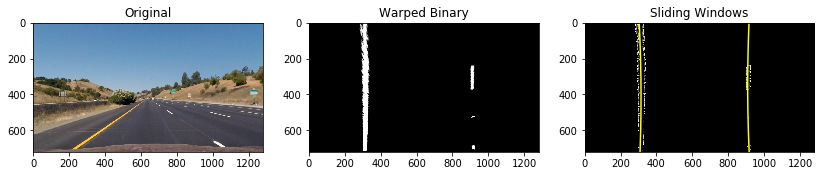

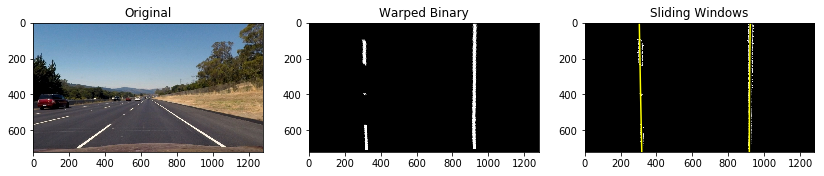

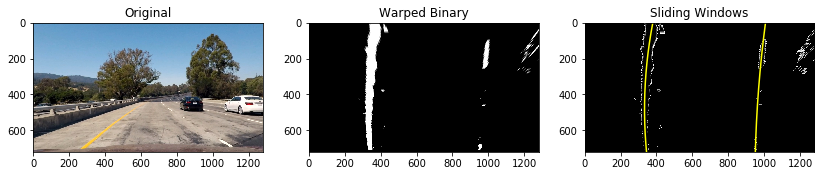

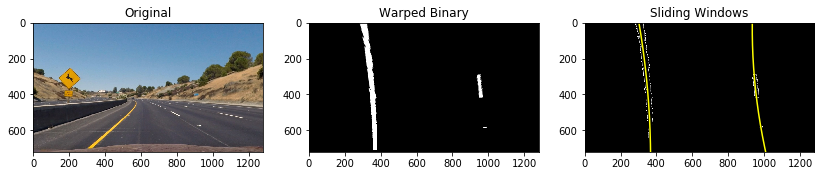

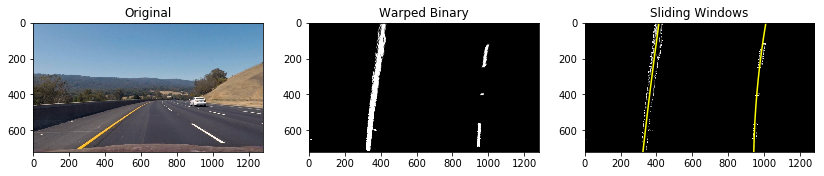

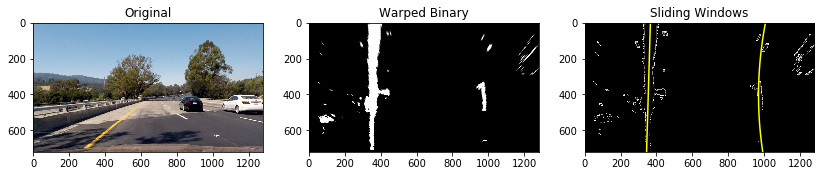

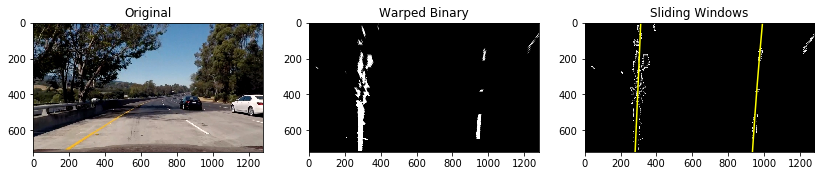

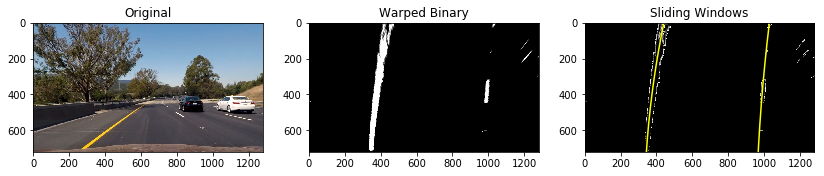

In [5]:
def sliding_search(binary_warped, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    else:
        left_fit = None
        left_fitx = None

    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        right_fix = None
        right_fitx = None

    if plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        return left_fitx, right_fitx, ploty, out_img
    return left_fitx, right_fitx, ploty


for imgpath in glob('./test_images/*.jpg'):
    img = camera.undistort(imread_rgb(imgpath))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped Binary')
    lfx, rfx, ploty, lanes = sliding_search(warped, plot=True)
    ax3.imshow(lanes, cmap='gray')
    ax3.plot(lfx, ploty, color='yellow')
    ax3.plot(rfx, ploty, color='yellow')
    ax3.set_title('Sliding Windows')
    plt.show()

# Curvature and Drawing

Here the polynomials are use to calculate the curvature of the lanes and the position of the car.

Next, the lane positions and a polygon are drawn to the original image.

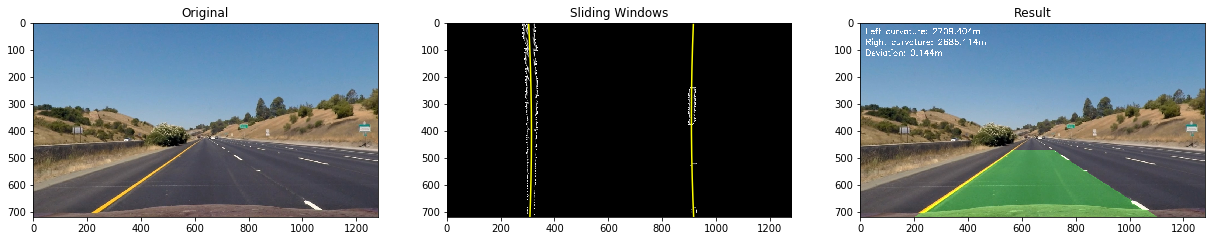

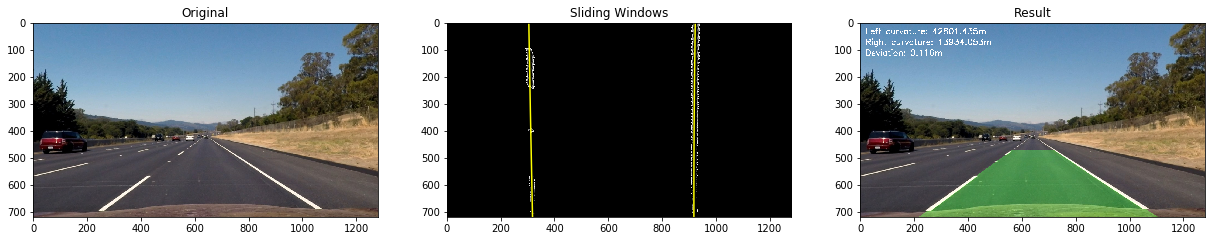

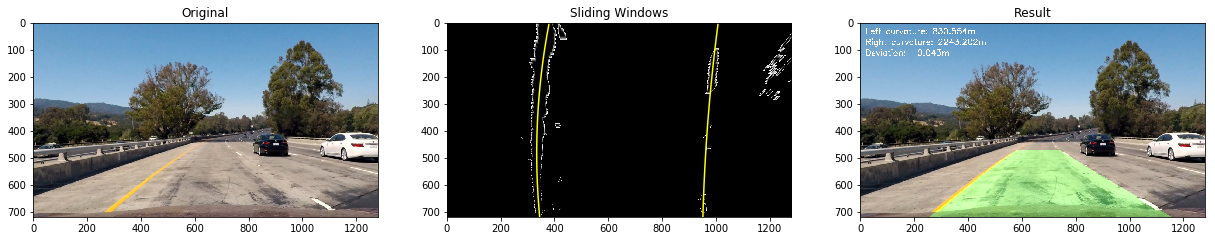

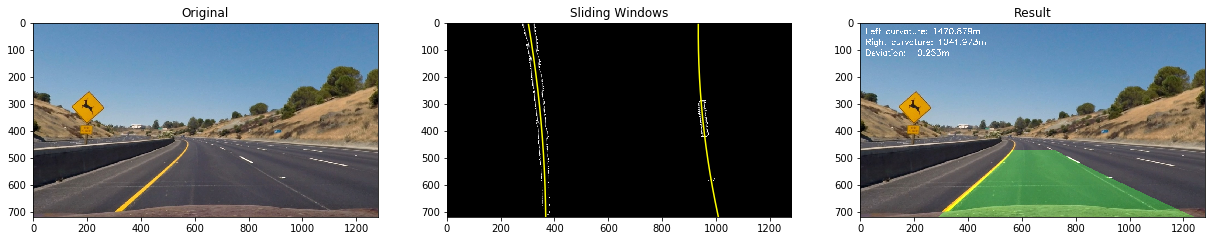

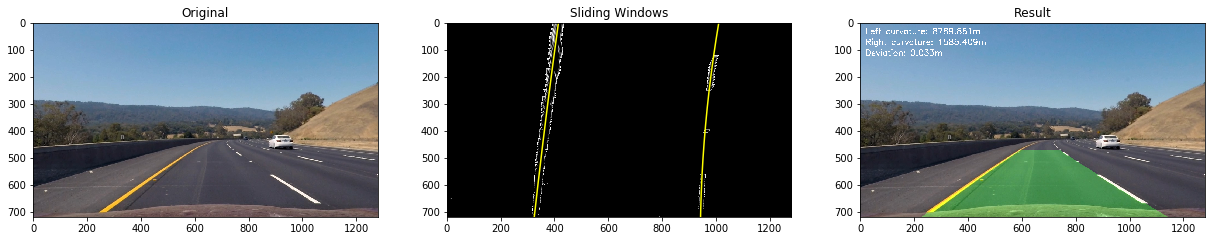

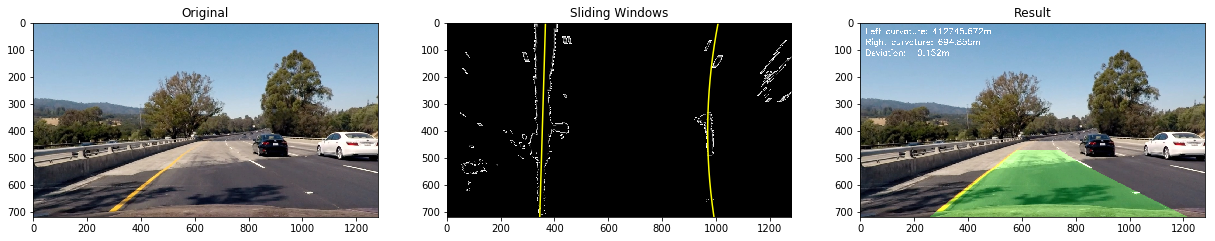

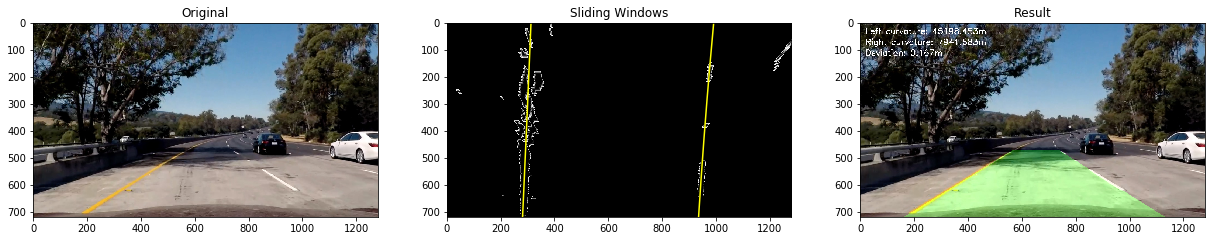

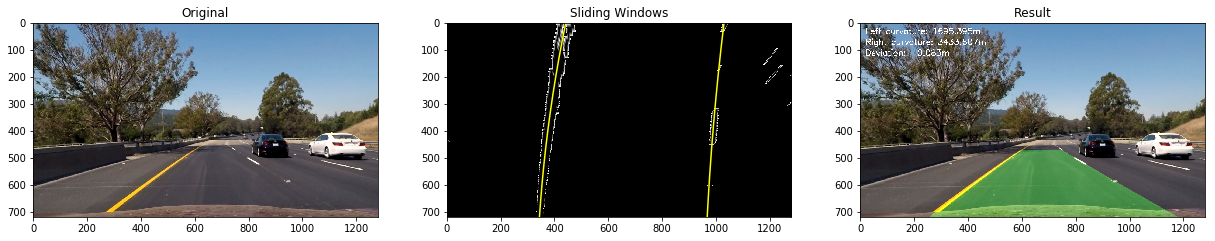

In [6]:
def calculate_curvature_deviation(left_fitx, right_fitx, ploty):
    x_mpp = 3.7/700  # 3.7m per 700 pixels, estimated from warped binaries
    y_mpp = 30.0/720 # 30m for the whole height of the warped binary
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2 # Lane center in pixels
    deviation = (1280 / 2 - lane_center) * x_mpp # Deviation from center converted to meters
    
    left_fitxm = np.polyfit(ploty * y_mpp, left_fitx * x_mpp, 2)
    right_fitxm = np.polyfit(ploty * y_mpp, right_fitx * x_mpp, 2)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitxm[0]*y_eval*y_mpp + left_fitxm[1])**2)**1.5) / np.absolute(2*left_fitxm[0])
    right_curverad = ((1 + (2*right_fitxm[0]*y_eval*y_mpp + right_fitxm[1])**2)**1.5) / np.absolute(2*right_fitxm[0])
    return left_curverad, right_curverad, deviation

def draw_lanes(undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def plot_back(undist, left_fitx, right_fitx, ploty):
    color_warp = draw_lanes(undist, left_fitx, right_fitx, ploty)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = camera.unwarp(color_warp)
    # Combine the result with the original image
    output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Annotate curvature and deviation
    left_curve, right_curve, deviation = calculate_curvature_deviation(left_fitx, right_fitx, ploty)
    cv2.putText(output, 'Left curvature: {:.3f}m'.format(left_curve), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(output, 'Right curvature: {:.3f}m'.format(right_curve), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(output, 'Deviation: {:.3f}m'.format(deviation), (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return output

for imgpath in glob('./test_images/*.jpg'):
    img = camera.undistort(imread_rgb(imgpath))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(21)
    ax1.imshow(img)
    ax1.set_title('Original')
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    lfx, rfx, ploty, lanes = sliding_search(warped, plot=True)
    ax2.imshow(lanes, cmap='gray')
    ax2.plot(lfx, ploty, color='yellow')
    ax2.plot(rfx, ploty, color='yellow')
    ax2.set_title('Sliding Windows')
    ax3.imshow(plot_back(img, lfx, rfx, ploty))
    ax3.set_title('Result')
    plt.show()

# Pipeline

Now taking everything toghether, a pipeline is built to process the project video:

1. Perform camera distortion correction
2. Apply the color filter to build the binary image where the lane pixels dominate
3. Apply birds-eye-view transformation
4. Use the sliding search technique (due to better results than the convolution technique) to find the lane pixels positions
5. Perform a polynomial fit of both lane pixels, drawing a polygon and lane lines on warped space
6. Apply the reverse warp to the drawings
7. Merge the drawings and undistorted image
8. Measure and annotate curvature, deviation

In [7]:
def process_frame(img):
    img = camera.undistort(img)
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    lfx, rfx, ploty = sliding_search(warped)
    return plot_back(img, lfx, rfx, ploty)

input_video = 'project_video.mp4'
output_video = 'output_{}'.format(input_video)

clip = VideoFileClip(input_video)
clip.fl_image(process_frame).write_videofile(output_video, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [01:29<00:00, 14.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 



# Improvements to the pipeline

The simple pipeline defined above could properly handle the project video, but isn't enough to handle the challenge ones, needing a few improvements:

1. Cache the results on each frame
2. Use a weighted average between frames to smooth out outliers
3. Use the cached lanes for sanity checking, refusing the ones found if they differ too much
4. Subsample by skipping every other frame to improve performance

In [8]:
alpha = 0.25
max_diff = 50

avg_lfx, avg_rfx, ploty = None, None, ploty
skip_frame = False

def process_frame_avg(img):
    global skip_frame
    img = camera.undistort(img)
    if not skip_frame:
        global avg_lfx
        global avg_rfx
        global ploty
        filtered = color_filter(img)
        warped = camera.warp(filtered)
        lfx, rfx, ploty = sliding_search(warped)
        if avg_lfx is None:
            avg_lfx = lfx
        if avg_rfx is None:
            avg_rfx = rfx

        if lfx is not None:
            diff = np.average(np.abs(avg_lfx - lfx))
            cv2.putText(img, 'Left diff: {:.2f}'.format(diff), (500, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            if diff < max_diff: # Drop and using previous diff to estimate position
                avg_lfx = alpha * lfx + (1 - alpha) * avg_lfx
        if rfx is not None:
            diff = np.average(np.abs(avg_rfx - rfx))
            cv2.putText(img, 'Right diff: {:.2f}'.format(diff), (500, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            if diff < max_diff:
                avg_rfx = alpha * rfx + (1 - alpha) * avg_rfx

    skip_frame = not skip_frame
    return plot_back(img, avg_lfx, avg_rfx, ploty)

input_video = 'challenge_video.mp4'
output_video = 'output_{}'.format(input_video)

clip = VideoFileClip(input_video)
clip.fl_image(process_frame_avg).write_videofile(output_video, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|██████████| 485/485 [00:27<00:00, 17.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 



# Further improvements

While able to tackle the challenge video, the harder one is still a mess. Here I'll implement another set of improvements, this time to help tune the pipeline.

1. Create classes to encapsulate and organize some work.
2. Implement a debug visualization.
3. Use VideoFileClip.subclip() to parse a small part of the video.

In [9]:
def writeOnImage(img, text, org):
    cv2.putText(img, text, org, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        

class Lane(object):
    
    def __init__(self, alpha, max_diff, max_reuse):
        self.alpha = alpha
        self.max_diff = max_diff
        self.max_reuse = max_reuse
        
        self.fitx = None
        self.failures = 0
        self.detected = False
    
    def update(self, fitx):
        if fitx is None:
            # Nothing found
            self.detected = False
        elif self.fitx is None:
            # First fit
            self.fitx = fitx
            self.detected = True
        else:
            # Sanity check, just the base of the lanes
            diff = np.abs(self.fitx[-1] - fitx[-1])
            if diff < self.max_diff:
                # Weighted average
                self.fitx = self.alpha * fitx + (1 - self.alpha) * self.fitx
                self.detected = True
            elif self.failures > self.max_reuse:
                # Drop cache and start again from current
                self.fitx = fitx
                self.detected = True
            else:
                # Just reuse the cached lane
                self.detected = False

        self.failures = 0 if self.detected else self.failures + 1
        return self.detected

    
class LaneFinder(object):
    
    def __init__(self, debug=False, alpha=0.5, max_diff=60, max_reuse=6):
        self.debug = debug
        self.left = Lane(alpha=alpha, max_diff=max_diff, max_reuse=max_reuse)
        self.right = Lane(alpha=alpha, max_diff=max_diff, max_reuse=max_reuse)

    def process_frame(self, img):
        img = camera.undistort(img)
        warped = camera.warp(img)
        filtered = color_filter(warped)
        lfx, rfx, ploty, lanes = sliding_search(filtered, plot=True)

        if not self.left.update(lfx) and self.debug:
            writeOnImage(img, "Left lane not detected", (40, 620))
        if not self.right.update(rfx) and self.debug:
            writeOnImage(img, "Right lane not detected", (40, 660))
        
        if self.left.detected and not self.right.detected:
            estimated_rfx = self.right.fitx - self.left.fitx + lfx
            self.right.update(estimated_rfx)
            if self.debug:
                writeOnImage(img, "Estimated right lane", (40, 700))

        if self.right.detected and not self.left.detected:
            estimated_lfx = self.left.fitx - self.right.fitx + rfx
            self.left.update(estimated_lfx)
            if self.debug:
                writeOnImage(img, "Estimated left lane", (40, 700))

        output = plot_back(img, self.left.fitx, self.right.fitx, ploty)
        
        if self.debug:
            size = (640, 360)
            res_warped = cv2.resize(warped, size)
            filtered = np.dstack([filtered, filtered, filtered])
            pts_left = np.array([np.transpose(np.vstack([self.left.fitx, ploty]))])
            cv2.polylines(filtered, np.int_(pts_left), False, (255, 0, 0), 3)
            pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right.fitx, ploty])))])
            cv2.polylines(filtered, np.int_(pts_right), False, (0, 0, 255), 3)
            res_lanes = cv2.resize(filtered, size)
            panel = np.hstack((res_warped, res_lanes))
            output = np.vstack((panel, output))
        
        return output

input_video = 'harder_challenge_video.mp4'
output_video = 'output_{}'.format(input_video)
lanefinder = LaneFinder(debug=True)

clip = VideoFileClip(input_video).subclip(0, 10)
clip.fl_image(lanefinder.process_frame).write_videofile(output_video, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output_harder_challenge_video.mp4
[MoviePy] Writing video output_harder_challenge_video.mp4


100%|█████████▉| 250/251 [00:24<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge_video.mp4 



# Further improvements

The debug visualization above shows the binary image must be improved so the pipeline sees only the lane pixels.

The warping can be improved as well, as hard corners leaves just a small portion of the lanes visible.

Finally, the sliding window search can use the previous lanes as a guide, further improving the performance of the pipeline. Combining this with subsampling, the pipeline can run in real-time.